In [1]:
"""
Preparation of reference data for 
"""

import os, sys
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import gc

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

# Load the environment variables

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'

# Coordinate Ref. System
utm13n = 32613  # UTM Zone 13N (Denver, CO)

print("Ready !")

Ready !


In [4]:
gdf_fp = os.path.join(maindir, 'data/spatial/raw/denver_data/training/denver_data_ocm_w_ztrax_matched_bounds.gpkg')
gdf = gpd.read_file(gdf_fp)
gdf = gdf.to_crs(utm13n) # local projection
print(f'Length of Denver data: {len(gdf)};')

Length of Denver data: 379907;


In [5]:
gdf.RoofCoverStndCode.unique()

array(['', 'TL', 'WS', 'CN', 'AP', 'RC', 'SL', 'ME', 'BU', 'TG', 'UR',
       'CS', 'SH'], dtype=object)

In [6]:
# add the class code categorical variable
gdf.loc[:, 'class_code'] = gdf['RoofCoverStndCode'].astype('category')
print(list(gdf['class_code'].unique()))

['', 'TL', 'WS', 'CN', 'AP', 'RC', 'SL', 'ME', 'BU', 'TG', 'UR', 'CS', 'SH']


In [7]:
# Drop footprints with no roof material information
gdf = gdf[gdf['class_code'] != '']
gdf.class_code.value_counts()

class_code
CS    92582
AP    15192
WS    11433
TL     3162
CN     2865
TG      518
SL      283
ME      200
RC       51
SH       24
BU        6
UR        1
          0
Name: count, dtype: int64

In [ ]:
# Remove footprints with no roof material code

In [8]:
# Create the area attribute and filter mismatches
gdf['areaUTM'] = [geom.area for geom in gdf.geometry]
gdf['areaUTMsqft'] = [geom.area * 10.7639 for geom in gdf.geometry]
# Calculate the percent difference between the area and reported lot size
gdf['areaPctDiff'] = (gdf['areaUTMsqft'] - gdf['LotSizeSquareFeet']).abs() / gdf['LotSizeSquareFeet'] * 100

# filter the footprints by distance metric (output from fuzzy join) and percent difference
gdf_ = gdf.loc[(gdf._distance <= 30) & (gdf.areaUTMsqft <= gdf.LotSizeSquareFeet)]
len(gdf_)

111483

In [9]:
gdf_.class_code.value_counts()

class_code
CS    86561
WS    10642
AP     8117
TL     2843
CN     2757
SL      230
TG      228
ME       40
RC       39
SH       22
BU        4
          0
UR        0
Name: count, dtype: int64

In [11]:
# Handle 'bad' classes
bad_classes = ['','BU','OT'] # empty, "Built Up", "other"

out_gdfs = []
for cl in gdf_.class_code.unique():

    if cl in bad_classes:
        continue

    _gdf = gdf_.loc[gdf_.class_code == cl]

    # skip small sample size
    if _gdf.shape[0] < 100:
        print(f'Class {cl} has shape {_gdf.shape} ... skipping ...')
        continue

    out_gdfs.append(_gdf)

# Concatenate the reference data
ref = pd.concat(out_gdfs)
print(ref['class_code'].value_counts())

del out_gdfs, _gdf
gc.collect()

Class RC has shape (39, 89) ... skipping ...
Class ME has shape (40, 89) ... skipping ...
Class SH has shape (22, 89) ... skipping ...
class_code
CS    86561
WS    10642
AP     8117
TL     2843
CN     2757
SL      230
TG      228
          0
BU        0
ME        0
RC        0
SH        0
UR        0
Name: count, dtype: int64


0

In [12]:
# Load the class code lookup table
lookup = pd.read_csv(os.path.join(maindir,'data/tabular/raw/variable_lookup/RoofCoverStndCode_encoding.csv'))
lookup.head(25)

,Code,Description,numcode
0,AL,Aluminum,1
1,AP,Asphalt,2
2,AS,Asbestos,3
3,BR,Bermuda,4
4,BU,Built Up,5
5,CN,Concrete,6
6,CS,Composition Shingle,7
7,FG,Fiberglass,8
8,GR,Gravel/rock,9
9,GY,Gypsum,10


In [13]:
# Create a unique ID column
ref['uid'] = ref.index + 1
ref['uid'] = ref['uid'].astype(str) + ref['class_code'].astype(str)

# Join to the lookup table to get the description
lookup = lookup[['Description','Code']]
lookup = lookup.rename(columns={"Code": "class_code","Description": "description"})
ref = ref.merge(lookup, on='class_code')

# Select the required columns
ref = ref[['uid', 'class_code', 'description', 'areaUTMsqft', 'LotSizeSquareFeet', 'geometry']]
ref = ref.rename(columns={"LotSizeSquareFeet": "lotSizeSqft"})
ref.head()

,uid,class_code,description,areaUTMsqft,lotSizeSqft,geometry
0,78TL,TL,Tile,271.028875,4710.0,"MULTIPOLYGON (((502162.154 4397355.647, 502162..."
1,269TL,TL,Tile,3885.053236,22307.0,"MULTIPOLYGON (((503091.622 4397021.987, 503101..."
2,490TL,TL,Tile,2018.268605,6250.0,"MULTIPOLYGON (((501990.912 4396754.28, 502007...."
3,497TL,TL,Tile,273.843801,6370.0,"MULTIPOLYGON (((502773.275 4396965.742, 502773..."
4,537TL,TL,Tile,281.649002,6000.0,"MULTIPOLYGON (((502162.107 4396885.437, 502168..."


In [14]:
desc_mapping = dict(zip(ref['class_code'], ref['description']))
print(f'Description map: \n{desc_mapping}')

Description map: 
{'TL': 'Tile', 'WS': 'Wood shake/shingle', 'CN': 'Concrete', 'AP': 'Asphalt', 'SL': 'Slate', 'TG': 'Tar and gravel', 'CS': 'Composition Shingle'}


In [ ]:
# Summary statistics for footprint area

In [15]:
# Calculate the longest side length of the building
area_stats = ref.groupby('class_code', observed=True).apply(footprint_area_stats, include_groups=False).reset_index()
area_stats

,class_code,mean_area,pct90_area,mean_side_length,std_side_length,max_side_length,pct90_longest_side
0,AP,220.275065,334.693436,15.382731,2.096756,139.575706,21.930871
1,CN,379.317451,590.036484,21.179419,3.249251,86.199473,34.789029
2,CS,173.869085,255.850890,13.564221,2.021024,137.451338,20.190239
3,SL,542.682291,1027.882964,27.105750,5.348559,95.974985,54.098619
4,TG,498.942272,824.956488,22.750724,6.634755,228.912871,49.078231
5,TL,261.383820,440.409775,16.510695,2.280716,102.425394,26.692685
6,WS,250.797337,393.927105,16.692924,2.598482,70.665041,27.523994


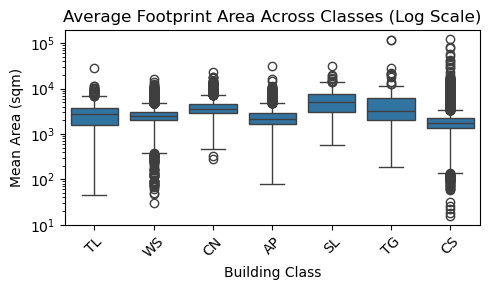

In [16]:
# Box plot for mean footprint area across classes
plt.figure(figsize=(5, 3))
sns.boxplot(x='class_code', y='areaUTMsqft', data=ref)
# Set the y-axis to log scale
plt.yscale('log')
plt.title('Average Footprint Area Across Classes (Log Scale)')
plt.ylabel('Mean Area (sqm)')
plt.xlabel('Building Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Map of reference data

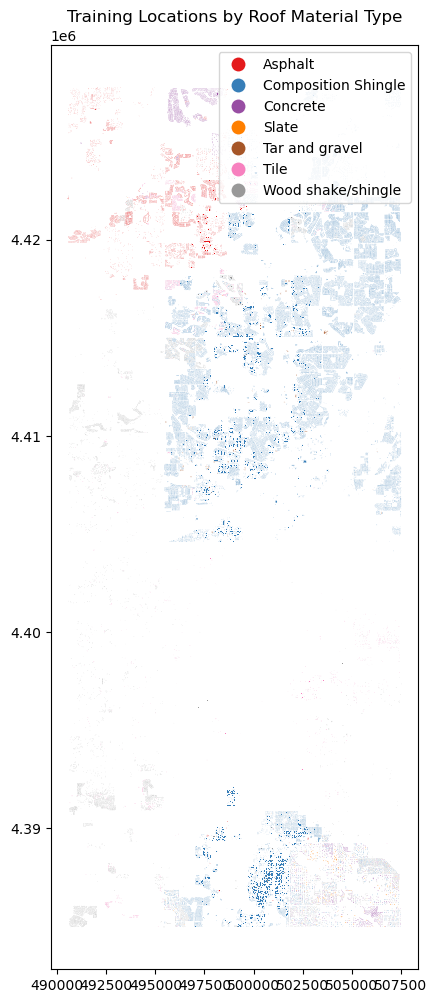

In [18]:
# Plot the training locations with colors based on roof type
fig, ax = plt.subplots(figsize=(8, 12))
ref.plot(column='description', ax=ax, legend=True, cmap='Set1', edgecolor='none')
plt.title('Training Locations by Roof Material Type')
plt.show()

In [19]:
# Save to geopackage
ref.to_file(os.path.join(maindir,'data/spatial/mod/denver_data/training/denver_data_reference_footprints.gpkg'))

In [20]:
gc.collect()

75